In [1]:
from __future__ import annotations
import pickle

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sstt

from incremental_hyser.hyser import hyser as hy

In [2]:
# results = pickle.load(open('./results/baseline_feb11.pkl', 'rb'))['results']

# RETEST:
# results = pickle.load(open('./results/retest_mar19_baseline.pkl', 'rb'))['results']
results = pickle.load(open('./results/retest_mar19_online.pkl', 'rb'))['results']


mae_dict = {
    'stage': {
        0: {'onedof': {'day': {}}, 'ndof': {'day': {}}, 'random': {'day': {}}},
        1: {'onedof': {'day': {}}, 'ndof': {'day': {}}, 'random': {'day': {}}},
        2: {'onedof': {'day': {}}, 'ndof': {'day': {}}, 'random': {'day': {}}},
    }
}

for idx_stage in [0, 1, 2]:
    for idx_day in range(hy.NUM_SESSIONS):
        mae_dict['stage'][idx_stage]['onedof']['day'][idx_day] = np.zeros((hy.NUM_SUBJECTS, hy.NUM_FINGERS, hy.NUM_TRIALS_ONEDOF, hy.NUM_FINGERS), dtype=np.float32)
        mae_dict['stage'][idx_stage]['ndof']['day'][idx_day] = np.zeros((hy.NUM_SUBJECTS, hy.NUM_COMBINATIONS_NDOF, hy.NUM_TRIALS_NDOF, hy.NUM_FINGERS), dtype=np.float32)
        mae_dict['stage'][idx_stage]['random']['day'][idx_day] = np.zeros((hy.NUM_SUBJECTS, hy.NUM_TRIALS_RANDOM, hy.NUM_FINGERS), dtype=np.float32)

        for idx_subj in range(hy.NUM_SUBJECTS):

            # onedof
            for idx_finger in range(hy.NUM_FINGERS):
                for idx_trial in range(hy.NUM_TRIALS_ONEDOF):
                    mae_dict['stage'][idx_stage]['onedof']['day'][idx_day][idx_subj, idx_finger, idx_trial] = \
                        results['subject'][idx_subj]['stage'][idx_stage]['onedof']['day'][idx_day]['finger'][idx_finger]['trial'][idx_trial]['mae']

            # ndof
            for idx_comb in range(hy.NUM_COMBINATIONS_NDOF):
                for idx_trial in range(hy.NUM_TRIALS_NDOF):
                    mae_dict['stage'][idx_stage]['ndof']['day'][idx_day][idx_subj, idx_comb, idx_trial] = \
                        results['subject'][idx_subj]['stage'][idx_stage]['ndof']['day'][idx_day]['combination'][idx_comb]['trial'][idx_trial]['mae']

            # random
            for idx_trial in range(hy.NUM_TRIALS_RANDOM):
                mae_dict['stage'][idx_stage]['random']['day'][idx_day][idx_subj, idx_trial] = \
                    results['subject'][idx_subj]['stage'][idx_stage]['random']['day'][idx_day]['trial'][idx_trial]['mae']

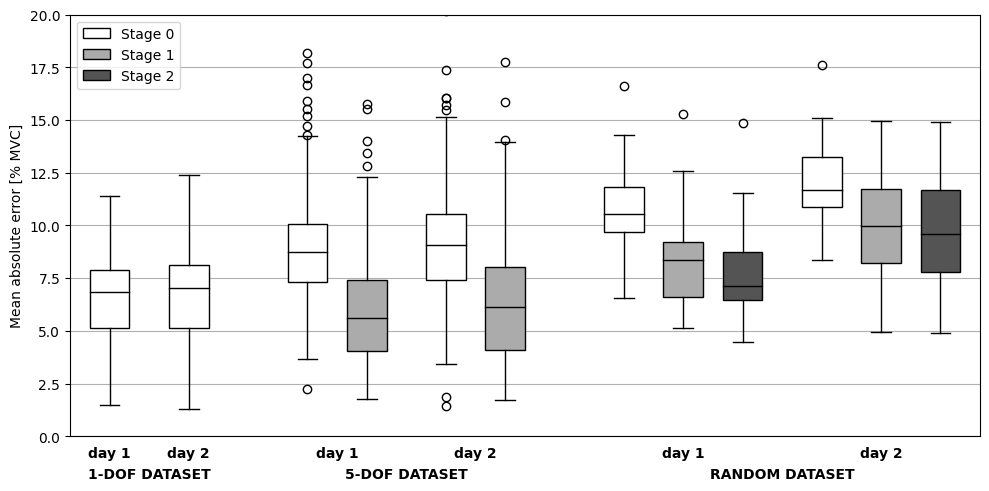

In [3]:
labels = [
    "Stage 0", "Stage 0",
    "Stage 0", "Stage 1",     "Stage 0", "Stage 1",
    "Stage 0", "Stage 1", "Stage 2",     "Stage 0", "Stage 1", "Stage 2",
]

WHITE = (1.00, 1.00, 1.00)
LIGHTGRAY = (0.67, 0.67, 0.67)
DARKGRAY = (0.33, 0.33, 0.33)
color_sequence = [
    WHITE, WHITE,
    WHITE, LIGHTGRAY, WHITE, LIGHTGRAY,
    WHITE, LIGHTGRAY, DARKGRAY, WHITE, LIGHTGRAY, DARKGRAY,
]
medianprops = {'color': 'black'}


fig, ax = plt.subplots(1, 1, figsize=(10.0, 5.0))

ax.set_ylabel("Mean absolute error [% MVC]")

'''
data = [
    # stage 0
    mae_dict['stage'][0]['onedof']['day'][0],
    mae_dict['stage'][0]['onedof']['day'][1],
    mae_dict['stage'][0]['ndof']['day'][0],
    mae_dict['stage'][0]['ndof']['day'][1],
    mae_dict['stage'][0]['random']['day'][0],
    mae_dict['stage'][0]['random']['day'][1],
    # stage 1
    mae_dict['stage'][1]['ndof']['day'][0],
    mae_dict['stage'][1]['ndof']['day'][1],
    mae_dict['stage'][1]['random']['day'][0],
    mae_dict['stage'][1]['random']['day'][1],
    # stage 2
    mae_dict['stage'][2]['random']['day'][0],
    mae_dict['stage'][2]['random']['day'][1],
]
'''
data = [
    mae_dict['stage'][0]['onedof']['day'][0],
    mae_dict['stage'][0]['onedof']['day'][1],

    mae_dict['stage'][0]['ndof']['day'][0],
    mae_dict['stage'][1]['ndof']['day'][0],
    mae_dict['stage'][0]['ndof']['day'][1],
    mae_dict['stage'][1]['ndof']['day'][1],
    
    mae_dict['stage'][0]['random']['day'][0],
    mae_dict['stage'][1]['random']['day'][0],
    mae_dict['stage'][2]['random']['day'][0],
    mae_dict['stage'][0]['random']['day'][1],
    mae_dict['stage'][1]['random']['day'][1],
    mae_dict['stage'][2]['random']['day'][1],
]

def aggr_flat(d: np.array[np.float32]) -> np.array[np.float32]:
    return np.median(d, axis=(-2, -1)).flatten() * 100.0  # to % for reviewer

positions = [
     0.5,  2.5,
     5.5,  7.0,  9.0, 10.5, 
    13.5, 15.0, 16.5, 18.5, 20.0, 21.5,
]

bp_dict = ax.boxplot(
    x=[aggr_flat(dt) for dt in data],  # [aggr_flat(data[i]) for i in [0, 1, 2, 6, 3, 7, 4, 8, 10, 5, 9, 11]],
    positions=positions,
    labels= [""] * 12,
    widths=1.0,
    medianprops=medianprops,
    patch_artist=True,
)

# COLORS?
idx = 0
for b in bp_dict['boxes']:
   lbl = ax.get_xticklabels()[idx].get_text()
   b.set_facecolor(color_sequence[idx])
   idx += 1

ax.legend(
    [bp_dict["boxes"][0], bp_dict["boxes"][3], bp_dict["boxes"][8]],
    ["Stage 0", "Stage 1", "Stage 2"],
    loc='upper left',
)

ax.grid(axis='y')
ax.set_xlim([-0.5, +22.5])
ax.set_ylim([0.0, 20.0])  # as % for revewer


# https://stackoverflow.com/questions/20532614/multiple-lines-of-x-tick-labels

# upper line
# ax.set_xticks([1.0, 2.0, 4.0, 5.0, 7.0, 8.0])
# ax.set_xticklabels(["Day 1", "Day 2", "Day 1", "Day 2", "Day 1", "Day 2"], weight='bold')
# lower line
ax.set_xticks(
    [
        0.5, 2.5, 6.25, 9.75, 15.0, 20.0,  # day
        1.5, 8.0, 17.5,  # dataset
    ],
)
ax.set_xticklabels(
    [
        "day 1", "day 2", "day 1", "day 2", "day 1", "day 2",  # day
        "1-DOF DATASET", "5-DOF DATASET", "RANDOM DATASET", # dataset
    ],
    weight='bold',
)

# vertical alignment of xtick labels
# https://stackoverflow.com/questions/20532614/multiple-lines-of-x-tick-labels
va = [
     0.00,  0.00,  0.00, 0.00, 0.00, 0.00,  # day
    -0.05, -0.05, -0.05,  # dataset
]
for t, y in zip(ax.get_xticklabels(), va):
    t.set_y(y)

ax.tick_params(axis='x', which='both', bottom=False)

plt.tight_layout()
plt.savefig("./plot_mae_stages.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [4]:
# not pre-aggregated
print(np.median(data[-1]))
print(sstt.iqr(data[-1]))

# pre-aggregated
print(np.median(aggr_flat(data[-1])))
print(sstt.iqr(aggr_flat(data[-1])))

# 0.08646361
# 0.05782429035753012
# 0.0910473
# 0.04024534858763218

# retested:
# 0.084675804
# 0.05751451198011637
# 0.089981385
# 0.03471312113106251

0.09453207
0.0652550458908081
9.581373
3.8949995040893555


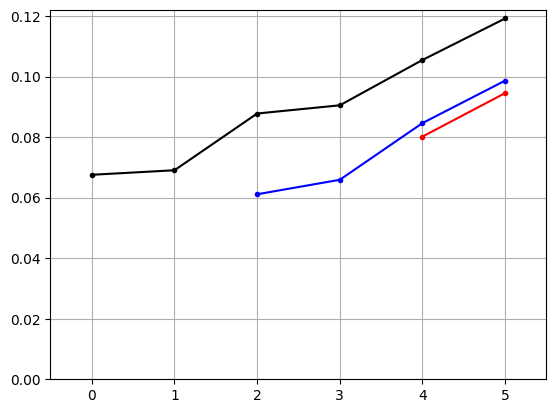

In [5]:
plt.figure()
plt.plot(
    [0, 1, 2, 3, 4, 5],
    [np.median(data[i]) for i in [0, 1, 2, 4, 6, 9]],
    'k.-',
)
plt.plot(
    [2, 3, 4, 5],
    [np.median(data[i]) for i in [3, 5, 7, 10]],
    'b.-',
)
plt.plot(
    [4, 5],
    [np.median(data[i]) for i in [8, 11]],
    'r.-',
)
plt.grid()
plt.axis([-0.5, +5.5, 0.0, None])
plt.show()